In [1]:
import skimage.external.tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils.data as dataf
import torch.nn as nn

In [2]:
Data = tiff.imread('data/CASI_SC_tif.tif')
TsLabel = tiff.imread('data/Test_sample.tif')
TrLabel = tiff.imread('data/Train_samples.tif')

In [3]:
batchsize = 128
patchsize = 16
LR = 0.001
EPOCH = 200
EPOCH2 = 200

In [4]:
[l, m, n] = Data.shape
Data = Data.astype('float32')
for i in range(l):
    minimal = Data[i, :, :].min()
    maximal = Data[i, :, :].max()
    Data[i, :, :] = (Data[i, :, :] - minimal)/(maximal - minimal)

In [5]:
x = Data
# boundary interpolation
temp = x[0, :, :]
pad_width = np.floor(patchsize/2)
pad_width = np.int(pad_width)
temp2 = np.pad(temp, pad_width, 'symmetric')
[m2, n2] = temp2.shape
x2 = np.empty((l, m2, n2), dtype='float32')

for i in range(l):
    temp = x[i, :, :]
    pad_width = np.floor(patchsize/2)
    pad_width = np.int(pad_width)
    temp2 = np.pad(temp, pad_width, 'symmetric')
    x2[i, :, :] = temp2

In [6]:
[ind1, ind2] = np.where(TrLabel != 0)
TrainNum = len(ind1)
TrainPatch = np.empty((TrainNum, l, patchsize, patchsize), dtype='float32')
TrainLabel = np.empty(TrainNum)
ind3 = ind1 + pad_width
ind4 = ind2 + pad_width
for i in range(len(ind1)):
    patch = x2[:, (ind3[i] - pad_width):(ind3[i] + pad_width), (ind4[i] - pad_width):(ind4[i] + pad_width)]
    patch = np.reshape(patch, (patchsize * patchsize, l))
    patch = np.transpose(patch)
    patch = np.reshape(patch, (l, patchsize, patchsize))
    TrainPatch[i, :, :, :] = patch
    patchlabel = TrLabel[ind1[i], ind2[i]]
    TrainLabel[i] = patchlabel

[ind1, ind2] = np.where(TsLabel != 0)
TestNum = len(ind1)
TestPatch = np.empty((TestNum, l, patchsize, patchsize), dtype='float32')
TestLabel = np.empty(TestNum)
ind3 = ind1 + pad_width
ind4 = ind2 + pad_width
for i in range(len(ind1)):
    patch = x2[:, (ind3[i] - pad_width):(ind3[i] + pad_width), (ind4[i] - pad_width):(ind4[i] + pad_width)]
    patch = np.reshape(patch, (patchsize * patchsize, l))
    patch = np.transpose(patch)
    patch = np.reshape(patch, (l, patchsize, patchsize))
    TestPatch[i, :, :, :] = patch
    patchlabel = TsLabel[ind1[i], ind2[i]]
    TestLabel[i] = patchlabel

print('Training size and testing size are:', TrainPatch.shape, 'and', TestPatch.shape)

Training size and testing size are: (2832, 144, 16, 16) and (12197, 144, 16, 16)


In [7]:
# step3: change data to the input type of PyTorch
TrainPatch = torch.from_numpy(TrainPatch)
TrainLabel = torch.from_numpy(TrainLabel)-1
TrainLabel = TrainLabel.long()
dataset = dataf.TensorDataset(TrainPatch, TrainLabel)
train_loader = dataf.DataLoader(dataset, batch_size=batchsize, shuffle=True)

TestPatch = torch.from_numpy(TestPatch)
TestLabel = torch.from_numpy(TestLabel)-1
TestLabel = TestLabel.long()

Classes = len(np.unique(TrainLabel))

# train_loader for CAE using training and test data together
TrainData2 = torch.cat([TrainPatch, TestPatch], 0)
TrainDataLabel2 = torch.cat([TrainPatch, TestPatch], 0)
dataset2 = dataf.TensorDataset(TrainData2, TrainDataLabel2)
train_loader2 = dataf.DataLoader(dataset2, batch_size=batchsize, shuffle=True)
print('Training size for reconstruction', TrainData2.shape)

Training size for reconstruction torch.Size([15029, 144, 16, 16])


In [8]:

# construct the reconstruction network
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        # encoding layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=l,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # nn.Dropout(0.5),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # nn.Dropout(0.5),
        )

        # decoding layers
        self.dconv1 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.dconv2 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )

        self.dconv3 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, l, 3, 1, 1),
            nn.BatchNorm2d(l),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.dconv1(x)
        x = self.dconv2(x)
        x = self.dconv3(x)
        x = x.view(x.size(0), -1)
        return x

In [9]:
ae = CAE()
ae.cuda()
print(ae)

optimizer = torch.optim.Adam(ae.parameters(), lr=LR)
loss_func = nn.MSELoss()

BestAcc = 100

CAE(
  (conv1): Sequential(
    (0): Conv2d(144, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dconv1): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): Conv2d(128, 64, kernel_size=(3, 3), 

In [10]:
# train the AE and save the best model
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader2):  # gives batch data
        b_x = b_x.cuda()
        output = ae(b_x)  # rnn output
        loss = loss_func(output, b_x.view(b_x.size(0), -1))  # cross entropy loss
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients

        if step % 50 == 0:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy())
            # save the parameters in network
            if loss.data.cpu().numpy() < BestAcc:
                torch.save(ae.state_dict(), 'net_params_CAERecons.pkl')
                BestAcc = loss.data.cpu().numpy()

Epoch:  0 | train loss: 0.2022
Epoch:  0 | train loss: 0.1423
Epoch:  0 | train loss: 0.1292
Epoch:  1 | train loss: 0.1274
Epoch:  1 | train loss: 0.1185
Epoch:  1 | train loss: 0.1120
Epoch:  2 | train loss: 0.1129
Epoch:  2 | train loss: 0.1025
Epoch:  2 | train loss: 0.0971
Epoch:  3 | train loss: 0.0942
Epoch:  3 | train loss: 0.0870
Epoch:  3 | train loss: 0.0829
Epoch:  4 | train loss: 0.0772
Epoch:  4 | train loss: 0.0754
Epoch:  4 | train loss: 0.0680
Epoch:  5 | train loss: 0.0659
Epoch:  5 | train loss: 0.0635
Epoch:  5 | train loss: 0.0626
Epoch:  6 | train loss: 0.0581
Epoch:  6 | train loss: 0.0524
Epoch:  6 | train loss: 0.0495
Epoch:  7 | train loss: 0.0491
Epoch:  7 | train loss: 0.0499
Epoch:  7 | train loss: 0.0431
Epoch:  8 | train loss: 0.0439
Epoch:  8 | train loss: 0.0434
Epoch:  8 | train loss: 0.0370
Epoch:  9 | train loss: 0.0381
Epoch:  9 | train loss: 0.0364
Epoch:  9 | train loss: 0.0322
Epoch:  10 | train loss: 0.0330
Epoch:  10 | train loss: 0.0308
Epoch:

Epoch:  85 | train loss: 0.0011
Epoch:  86 | train loss: 0.0017
Epoch:  86 | train loss: 0.0012
Epoch:  86 | train loss: 0.0014
Epoch:  87 | train loss: 0.0012
Epoch:  87 | train loss: 0.0011
Epoch:  87 | train loss: 0.0012
Epoch:  88 | train loss: 0.0015
Epoch:  88 | train loss: 0.0009
Epoch:  88 | train loss: 0.0013
Epoch:  89 | train loss: 0.0010
Epoch:  89 | train loss: 0.0016
Epoch:  89 | train loss: 0.0011
Epoch:  90 | train loss: 0.0010
Epoch:  90 | train loss: 0.0013
Epoch:  90 | train loss: 0.0011
Epoch:  91 | train loss: 0.0010
Epoch:  91 | train loss: 0.0011
Epoch:  91 | train loss: 0.0010
Epoch:  92 | train loss: 0.0010
Epoch:  92 | train loss: 0.0012
Epoch:  92 | train loss: 0.0011
Epoch:  93 | train loss: 0.0015
Epoch:  93 | train loss: 0.0011
Epoch:  93 | train loss: 0.0012
Epoch:  94 | train loss: 0.0015
Epoch:  94 | train loss: 0.0012
Epoch:  94 | train loss: 0.0011
Epoch:  95 | train loss: 0.0011
Epoch:  95 | train loss: 0.0010
Epoch:  95 | train loss: 0.0011
Epoch:  

Epoch:  169 | train loss: 0.0008
Epoch:  169 | train loss: 0.0007
Epoch:  169 | train loss: 0.0008
Epoch:  170 | train loss: 0.0009
Epoch:  170 | train loss: 0.0008
Epoch:  170 | train loss: 0.0009
Epoch:  171 | train loss: 0.0012
Epoch:  171 | train loss: 0.0012
Epoch:  171 | train loss: 0.0010
Epoch:  172 | train loss: 0.0008
Epoch:  172 | train loss: 0.0008
Epoch:  172 | train loss: 0.0010
Epoch:  173 | train loss: 0.0008
Epoch:  173 | train loss: 0.0008
Epoch:  173 | train loss: 0.0009
Epoch:  174 | train loss: 0.0007
Epoch:  174 | train loss: 0.0008
Epoch:  174 | train loss: 0.0007
Epoch:  175 | train loss: 0.0009
Epoch:  175 | train loss: 0.0008
Epoch:  175 | train loss: 0.0008
Epoch:  176 | train loss: 0.0008
Epoch:  176 | train loss: 0.0008
Epoch:  176 | train loss: 0.0009
Epoch:  177 | train loss: 0.0008
Epoch:  177 | train loss: 0.0007
Epoch:  177 | train loss: 0.0010
Epoch:  178 | train loss: 0.0010
Epoch:  178 | train loss: 0.0010
Epoch:  178 | train loss: 0.0007
Epoch:  17

In [11]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=l,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # nn.Dropout(0.5),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # nn.MaxPool2d(2),
            nn.AdaptiveMaxPool2d(1),
            # nn.Dropout(0.5),
        )

        self.output = nn.Linear(128, Classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x

In [12]:
classifier = Classifier()
classifier.cuda()
print(classifier)

optimizer = torch.optim.Adam(classifier.parameters(), lr=LR)
loss_func2 = nn.CrossEntropyLoss()

# load pre-trained ae parameters
model_dict = classifier.state_dict()
pretrained_dict = torch.load('net_params_CAERecons.pkl')
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
classifier.load_state_dict(model_dict)

Classifier(
  (conv1): Sequential(
    (0): Conv2d(144, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AdaptiveMaxPool2d(output_size=1)
  )
  (output): Linear(in_features=128, out_features=15, bias=True)
)


<All keys matched successfully>

In [13]:
BestAcc = 0

# training and testing
for epoch in range(EPOCH2):
    for step, (b_x, b_y) in enumerate(train_loader):  # gives batch data
        b_x = b_x.cuda()
        b_y = b_y.cuda()

        output = classifier(b_x)  # rnn output

        loss = loss_func2(output, b_y)  # cross entropy loss
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients

        if step % 50 == 0:

            classifier.eval()  # in the testing phase, we don't need to use dropout

            # divide test set into many subsets
            pred_y = np.empty((len(TestLabel)), dtype='float32')
            number = len(TestLabel) // 5000
            for i in range(number):
                temp = TestPatch[i * 5000:(i + 1) * 5000, :, :]
                temp = temp.cuda()
                temp2 = classifier(temp)
                temp3 = torch.max(temp2, 1)[1].squeeze()
                pred_y[i * 5000:(i + 1) * 5000] = temp3.cpu()
                del temp, temp2, temp3

            if (i + 1) * 5000 < len(TestLabel):
                temp = TestPatch[(i + 1) * 5000:len(TestLabel), :, :]
                temp = temp.cuda()
                temp2 = classifier(temp)
                temp3 = torch.max(temp2, 1)[1].squeeze()
                pred_y[(i + 1) * 5000:len(TestLabel)] = temp3.cpu()
                del temp, temp2, temp3

            pred_y = torch.from_numpy(pred_y).long()
            accuracy = torch.sum(pred_y == TestLabel).type(torch.FloatTensor) / TestLabel.size(0)
            # test_output = rnn(TestData)
            # pred_y = torch.max(test_output, 1)[1].cuda().data.squeeze()
            # accuracy = torch.sum(pred_y == TestDataLabel).type(torch.FloatTensor) / TestDataLabel.size(0)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy(), '| test accuracy: %.2f' % accuracy)

            if accuracy > BestAcc:
                torch.save(classifier.state_dict(), 'net_params_CAEClass.pkl')
                BestAcc = accuracy

            classifier.train()  # in the training phase, we need to use dropout again


Epoch:  0 | train loss: 3.0158 | test accuracy: 0.09
Epoch:  1 | train loss: 2.2580 | test accuracy: 0.26
Epoch:  2 | train loss: 1.7973 | test accuracy: 0.45
Epoch:  3 | train loss: 1.4601 | test accuracy: 0.48
Epoch:  4 | train loss: 1.2486 | test accuracy: 0.55
Epoch:  5 | train loss: 0.9938 | test accuracy: 0.59
Epoch:  6 | train loss: 0.6651 | test accuracy: 0.59
Epoch:  7 | train loss: 0.4637 | test accuracy: 0.58
Epoch:  8 | train loss: 0.4497 | test accuracy: 0.63
Epoch:  9 | train loss: 0.3289 | test accuracy: 0.71
Epoch:  10 | train loss: 0.2187 | test accuracy: 0.68
Epoch:  11 | train loss: 0.2059 | test accuracy: 0.73
Epoch:  12 | train loss: 0.1577 | test accuracy: 0.74
Epoch:  13 | train loss: 0.1078 | test accuracy: 0.75
Epoch:  14 | train loss: 0.0880 | test accuracy: 0.71
Epoch:  15 | train loss: 0.0792 | test accuracy: 0.77
Epoch:  16 | train loss: 0.0591 | test accuracy: 0.76
Epoch:  17 | train loss: 0.0613 | test accuracy: 0.75
Epoch:  18 | train loss: 0.0442 | test

Epoch:  151 | train loss: 0.0002 | test accuracy: 0.81
Epoch:  152 | train loss: 0.0003 | test accuracy: 0.81
Epoch:  153 | train loss: 0.0001 | test accuracy: 0.81
Epoch:  154 | train loss: 0.0005 | test accuracy: 0.81
Epoch:  155 | train loss: 0.0006 | test accuracy: 0.71
Epoch:  156 | train loss: 0.0071 | test accuracy: 0.76
Epoch:  157 | train loss: 0.0029 | test accuracy: 0.80
Epoch:  158 | train loss: 0.0019 | test accuracy: 0.75
Epoch:  159 | train loss: 0.0010 | test accuracy: 0.76
Epoch:  160 | train loss: 0.0026 | test accuracy: 0.74
Epoch:  161 | train loss: 0.0017 | test accuracy: 0.79
Epoch:  162 | train loss: 0.0013 | test accuracy: 0.80
Epoch:  163 | train loss: 0.0011 | test accuracy: 0.80
Epoch:  164 | train loss: 0.0005 | test accuracy: 0.80
Epoch:  165 | train loss: 0.0008 | test accuracy: 0.80
Epoch:  166 | train loss: 0.0013 | test accuracy: 0.80
Epoch:  167 | train loss: 0.0004 | test accuracy: 0.80
Epoch:  168 | train loss: 0.0004 | test accuracy: 0.80
Epoch:  16

In [14]:
classifier.load_state_dict(torch.load('net_params_CAEClass.pkl'))
classifier.eval()
pred_y = np.empty((len(TestLabel)), dtype='float32')
number = len(TestLabel)//5000
for i in range(number):
    temp = TestPatch[i*5000:(i+1)*5000, :, :]
    temp = temp.cuda()
    temp2 = classifier(temp)
    temp3 = torch.max(temp2, 1)[1].squeeze()
    pred_y[i*5000:(i+1)*5000] = temp3.cpu()
    del temp, temp2, temp3

if (i+1)*5000 < len(TestLabel):
    temp = TestPatch[(i+1)*5000:len(TestLabel), :, :]
    temp = temp.cuda()
    temp2 = classifier(temp)
    temp3 = torch.max(temp2, 1)[1].squeeze()
    pred_y[(i+1)*5000:len(TestLabel)] = temp3.cpu()
    del temp, temp2, temp3

pred_y = torch.from_numpy(pred_y).long()
OA = torch.sum(pred_y == TestLabel).type(torch.FloatTensor) / TestLabel.size(0)

Classes = np.unique(TestLabel)
EachAcc = np.empty(len(Classes))

for i in range(len(Classes)):
    cla = Classes[i]
    right = 0
    sum = 0

    for j in range(len(TestLabel)):
        if TestLabel[j] == cla:
            sum += 1
        if TestLabel[j] == cla and pred_y[j] == cla:
            right += 1

    EachAcc[i] = right.__float__()/sum.__float__()


print(OA)
print(EachAcc)

tensor(0.8190)
[0.79012346 0.95488722 0.75049505 0.96306818 0.94791667 0.66433566
 0.84701493 0.70180437 0.82341832 0.78571429 0.76565465 0.78001921
 0.64912281 0.91497976 0.60465116]


In [15]:
part = 5000
pred_all = np.empty((m*n, 1), dtype='float32')

number = m*n//part
for i in range(number):
    D = np.empty((part, l, patchsize, patchsize), dtype='float32')
    count = 0
    for j in range(i*part, (i+1)*part):
        row = j//n
        col = j - row*n
        row2 = row + pad_width
        col2 = col + pad_width
        patch = x2[:, (row2 - pad_width):(row2 + pad_width), (col2 - pad_width):(col2 + pad_width)]
        patch = np.reshape(patch, (patchsize * patchsize, l))
        patch = np.transpose(patch)
        patch = np.reshape(patch, (l, patchsize, patchsize))
        D[count, :, :, :] = patch
        count += 1

    temp = torch.from_numpy(D)
    temp = temp.cuda()
    temp2 = classifier(temp)
    temp3 = torch.max(temp2, 1)[1].squeeze()
    pred_all[i*part:(i+1)*part, 0] = temp3.cpu()
    del temp, temp2, temp3, D

if (i+1)*part < m*n:
    D = np.empty((m*n-(i+1)*part, l, patchsize, patchsize), dtype='float32')
    count = 0
    for j in range((i+1)*part, m*n):
        row = j // n
        col = j - row * n
        row2 = row + pad_width
        col2 = col + pad_width
        patch = x2[:, (row2 - pad_width):(row2 + pad_width), (col2 - pad_width):(col2 + pad_width)]
        patch = np.reshape(patch, (patchsize * patchsize, l))
        patch = np.transpose(patch)
        patch = np.reshape(patch, (l, patchsize, patchsize))
        D[count, :, :, :] = patch
        count += 1

    temp = torch.from_numpy(D)
    temp = temp.cuda()
    temp2 = classifier(temp)
    temp3 = torch.max(temp2, 1)[1].squeeze()
    pred_all[(i + 1) * part:m*n, 0] = temp3.cpu()
    del temp, temp2, temp3, D


pred_all = np.reshape(pred_all, (m, n)) + 1
OA = OA.numpy()
pred_y = pred_y.cpu()
pred_y = pred_y.numpy()
TestDataLabel = TestLabel.cpu()
TestDataLabel = TestDataLabel.numpy()

In [16]:
tiff.imsave('pred_cae.tif', pred_all)
# pred_all = tiff.imread('pred_cae.tif')

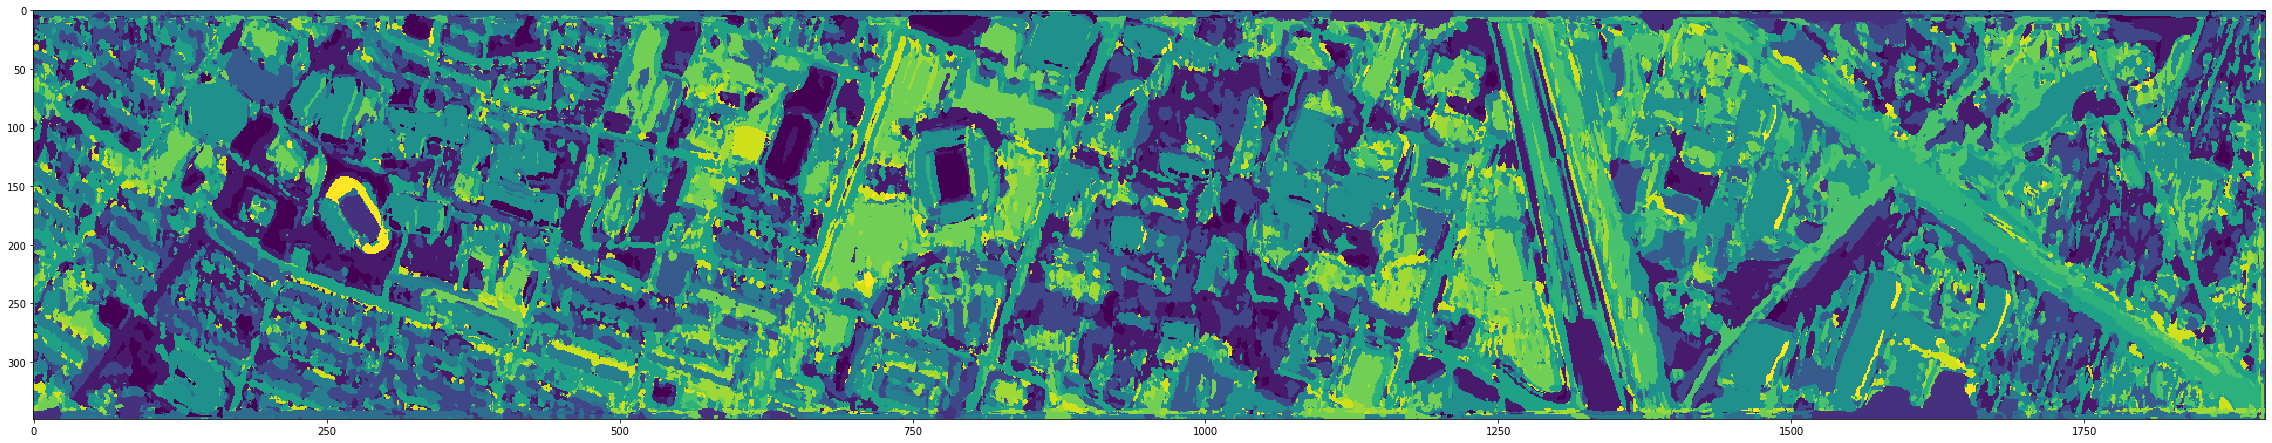

In [17]:
plt.figure(figsize=(40,40))
plt.imshow(pred_all)
plt.show()